In [1]:
import zipfile
import os

# Define the directory where the dataset zip file is located
zip_file_path = 'Anantasana.zip'
extracted_folder_path = 'Anantasana_dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Define the directory where the extracted images are located
data_dir = 'Anantasana_dataset'

# Use ImageDataGenerator to load and preprocess the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and preprocessing parameters
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the dataset into training and validation sets
)

# Load images from the specified directory with class labels
img_width, img_height = 64, 64
image_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),  # Define the dimensions for the images
    batch_size=32,
    class_mode='categorical',  # This is for multi-class classification
    shuffle=True,
    subset='training'  # Specify whether to load the training or validation set
)


Found 940 images belonging to 1 classes.


11501568/11490434 [==============================] - 2s 0us/step
0 [D loss: 0.6161480844020844, acc.: 48.4375] [G loss: 0.6387162208557129]


FileNotFoundError: [Errno 2] No such file or directory: 'images/mnist_0.png'

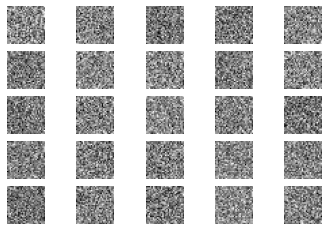

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Define the dimensions of the input noise vector
noise_dim = 100

# Define the dimensions of the MNIST images
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define discriminator and generator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator()

# Combined model (stacked generator and discriminator)
z = tf.keras.Input(shape=(noise_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training
def train(epochs, batch_size, save_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_imgs(epoch)
    
    print("Training completed!")

# Save generated images
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

# Set hyperparameters and train the GAN
epochs = 30000
batch_size = 32
save_interval = 1000

train(epochs, batch_size, save_interval)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dimensions of the input noise vector
noise_dim = 100

# Define the dimensions of the Anantasana images
img_rows = 64
img_cols = 64
channels = 3  # Assuming RGB images
img_shape = (img_rows, img_cols, channels)

# Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define discriminator and generator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator()

# Combined model (stacked generator and discriminator)
z = tf.keras.Input(shape=(noise_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Load and preprocess the Anantasana dataset using ImageDataGenerator
data_dir = 'Anantasana_dataset'

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

img_width, img_height = 64, 64
batch_size = 32

image_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Training
def train(epochs, batch_size, save_interval):
    num_batches = len(image_data)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            imgs, _ = image_data.next()  # Retrieve batch of images and labels

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_imgs(epoch)
    
    print("Training completed!")

# Save generated images
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/anantasana_%d.png" % epoch)
    plt.close()

# Set hyperparameters and train the GAN
epochs = 30000
batch_size = 32
save_interval = 1000

train(epochs, batch_size, save_interval)


Found 940 images belonging to 1 classes.


ValueError: Data cardinality is ambiguous:
  x sizes: 12
  y sizes: 32
Make sure all arrays contain the same number of samples.

In [7]:
import os

# Ensure that the "images" directory exists
os.makedirs("images_gen", exist_ok=True)


In [13]:
import os

# Ensure that the "images" directory exists
os.makedirs("images_gen1", exist_ok=True)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dimensions of the input noise vector
noise_dim = 100

# Define the dimensions of the Anantasana images
img_rows = 64
img_cols = 64
channels = 3  # Assuming RGB images
img_shape = (img_rows, img_cols, channels)

# Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define discriminator and generator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator()

# Combined model (stacked generator and discriminator)
z = tf.keras.Input(shape=(noise_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Load and preprocess the Anantasana dataset using ImageDataGenerator
data_dir = 'Anantasana_dataset'

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

img_width, img_height = 64, 64
batch_size = 32

image_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Training
def train(epochs, batch_size, save_interval):
    num_batches = len(image_data)

    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            imgs, _ = image_data.next()  # Retrieve batch of images and labels
            batch_size = imgs.shape[0]  # Get the batch size
            
            # Generate labels for the batch
            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            # Ensure that the batch size is consistent for the noise input to the generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(noise)

            # Train the discriminator with the current batch
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generate new noise for the next batch
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # Train the generator with the current batch
            g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_imgs(epoch)
    
    print("Training completed!")

# Save generated images
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images_gen/anantasana_%d.png" % epoch)
    plt.close()

# Set hyperparameters and train the GAN
epochs = 300
batch_size = 32
save_interval = 1000

train(epochs, batch_size, save_interval)


Found 940 images belonging to 1 classes.
0 [D loss: 0.07416234695119783, acc.: 100.0] [G loss: 2.623337507247925]
1 [D loss: 0.03460368770174682, acc.: 100.0] [G loss: 3.5809173583984375]
2 [D loss: 0.016076748215709813, acc.: 100.0] [G loss: 4.075965881347656]
3 [D loss: 0.01908460952108726, acc.: 100.0] [G loss: 4.812191009521484]
4 [D loss: 0.10845631435222458, acc.: 95.83333432674408] [G loss: 5.971384525299072]
5 [D loss: 1.3954204320907593, acc.: 54.16666679084301] [G loss: 0.5415820479393005]
6 [D loss: 0.2332166172813004, acc.: 87.5] [G loss: 1.8000656366348267]


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dimensions of the input noise vector
noise_dim = 100

# Define the dimensions of the Anantasana images
img_rows = 64
img_cols = 64
channels = 3  # Assuming RGB images
img_shape = (img_rows, img_cols, channels)

# Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define discriminator and generator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator()

# Combined model (stacked generator and discriminator)
z = tf.keras.Input(shape=(noise_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Load and preprocess the Anantasana dataset using ImageDataGenerator
data_dir = 'Anantasana_dataset'

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

img_width, img_height = 64, 64
batch_size = 32

image_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Training
def train(epochs, batch_size, save_interval):
    num_batches = len(image_data)

    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            imgs, _ = image_data.next()  # Retrieve batch of images and labels
            batch_size = imgs.shape[0]  # Get the batch size
            
            # Generate labels for the batch
            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            # Ensure that the batch size is consistent for the noise input to the generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(noise)

            # Train the discriminator with the current batch
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generate new noise for the next batch
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # Train the generator with the current batch
            g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_imgs(epoch)
    
    print("Training completed!")

# Save generated images
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images_gen1/anantasana_%d.png" % epoch)
    plt.close()

# Set hyperparameters and train the GAN
epochs = 20
batch_size = 32
save_interval = 1000

train(epochs, batch_size, save_interval)


Found 940 images belonging to 1 classes.
0 [D loss: 0.06500852026510984, acc.: 100.0] [G loss: 2.542813777923584]
1 [D loss: 0.02009841302060522, acc.: 100.0] [G loss: 3.469463586807251]
2 [D loss: 0.02425248152576387, acc.: 100.0] [G loss: 4.053108215332031]
3 [D loss: 0.008916212798794731, acc.: 100.0] [G loss: 4.685882091522217]
4 [D loss: 0.6923452131450176, acc.: 75.0] [G loss: 3.926114320755005]
5 [D loss: 0.8146319389921667, acc.: 58.33333358168602] [G loss: 1.8223137855529785]
6 [D loss: 0.2524955029366538, acc.: 83.33333432674408] [G loss: 2.2905657291412354]
7 [D loss: 0.2827753871679306, acc.: 91.66666567325592] [G loss: 1.1661875247955322]
8 [D loss: 0.6491593569517136, acc.: 62.5] [G loss: 0.39600899815559387]
9 [D loss: 0.23630995955318213, acc.: 91.66666567325592] [G loss: 1.326003909111023]
10 [D loss: 0.22182751772925258, acc.: 91.66666567325592] [G loss: 1.7635082006454468]
11 [D loss: 0.27452005073428154, acc.: 95.83333432674408] [G loss: 1.3288530111312866]
12 [D lo